In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PYG_GRAPHS = torch.load("data/processed/pyg_graphs_384D.pt", weights_only=False)

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


In [2]:
## HELPER FUNCTIONS FOR CREATING AND TRAINING MODEL
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

from typing import Dict, Any, Type, Optional

def create_and_describe_model(model_args: Dict[str, Any], model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN) -> Optional[MultitaskDebateGNN]:
    """Build the model from args, print a summary, and return the instance (or None on failure)."""
    try:
        model = model_class(**model_args)
        print("Model created:")
        print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
        print(f"   Mode: {model.mode}")
        print(f"   Input dim: {model_args['in_dim']}")
        print(f"   Hidden dim: {model_args['hidden_dim']}")
        print(f"   Embedding dim: {model_args['emb_dim']}")
        print(f"   Number of layers: {model_args['num_layers']}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

        # Show model structure
        print("\nModel Structure:")
        print(model)
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def run_cv_training(
    graph_data,
    model_args: dict,
    train_args: dict,
    model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN,
    live_plot: bool = False,):
    """
    Runs cross-validation training with cleanup and plotting.
    Returns (model, results, cv_history) or (None, None, None) on failure.
    """
    import gc, traceback
    import torch

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        model, results, cv_history = train_gnn_live(
            all_graphs=getattr(graph_data, "pyg_graphs", graph_data),
            model_args=model_args,
            train_args=train_args,
            model_class=model_class,
            live_plot=live_plot,
        )
        plot_cv_losses(cv_history=cv_history)
        return model, results, cv_history
    except Exception as e:
        print(f"Training error: {e}")
        traceback.print_exc()
        return None, None, None

In [3]:
# BASE MODEL AND TRAINING ARGS (shared across all variants)
BASE_MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    neg_attr_weight = 0.3,
    dropout = 0.15,
)

ECC_KWARGS = dict(
    edge_mlp_dropout = 0.1,
    keep_prob = 0.8,
    conf_dim = 1,
    stance_dim = 3
)

BASE_TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    val_n_last = 1, # or val_pct_last = 0.25 (pick either one)
    val_gap_n = 1,
    task_weights = {"link": 1.0, "conf": 1.0, "stance": 1.0}
)

# To store cv results later
TRAIN_RESULTS = {
    "3-ECC": None,
    "1-ECC-2-SAGE": None,
    "1-SAGE-2-ECC": None,
    "2-SAGE-1-ECC": None,
}
TRAINED_MODELS = {
    "3-ECC": None,
    "1-ECC-2-SAGE": None,
    "1-SAGE-2-ECC": None,
    "2-SAGE-1-ECC": None,
}

In [4]:
# DEFINE VARIANTS ARGS

# 1. 3-ECC -> Full
_3ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls=ECCConv,
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 2. 1-ECC-2-SAGE -> Full
_1ecc_2sage_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[ECCConv, SAGEConv, SAGEConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 3. 1-SAGE-2-ECC -> Full
_1sage_2ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, ECCConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 4. 2-SAGE-1-ECC -> Full
_2sage_1ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, SAGEConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

### **3-ECC** (Full)

Training 3-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
  - Avg 

  - Confidence correlations: disagree:+0.084, neutral:-0.184, agree:+0.084

Training for Test Subreddit: 0

Data Split with Temporal Gap (1 timesteps):
  - Training: 3 subreddits + early timesteps from val 1 → 52 graphs
    Train subreddits: [2, 3, 4, '1 (partial)']
  - Validation: Subreddit 1 latest timestep(s): [9] → 1 graph(s)
  - Temporal Gap (g=1): Subreddit 1 timestep(s) skipped: [8]
  - Testing: Subreddit 0 → 23 graphs

Edge Attribute (Training):
  - Confidence: μ=0.537, σ=0.381
  - Stance dist: [0.382, 0.240, 0.378] (disagree/neutral/agree)
  - Confidence correlations: disagree:+0.077, neutral:-0.201, agree:+0.100

Edge Attribute (Validation (Sub 1)):
  - Confidence: μ=0.602, σ=0.389
  - Stance dist: [0.223, 0.235, 0.542] (disagree/neutral/agree)
  - Confidence correlations: disagree:-0.003, neutral:-0.088, agree:+0.077

Loss Balancing:
  - Link pos_weight: 50.000 (pos/neg ratio: 0.0015)
  - Stance weights:  [2.615, 4.167, 2.649]

Model Configs:
  - Total parameters: 25,718,472

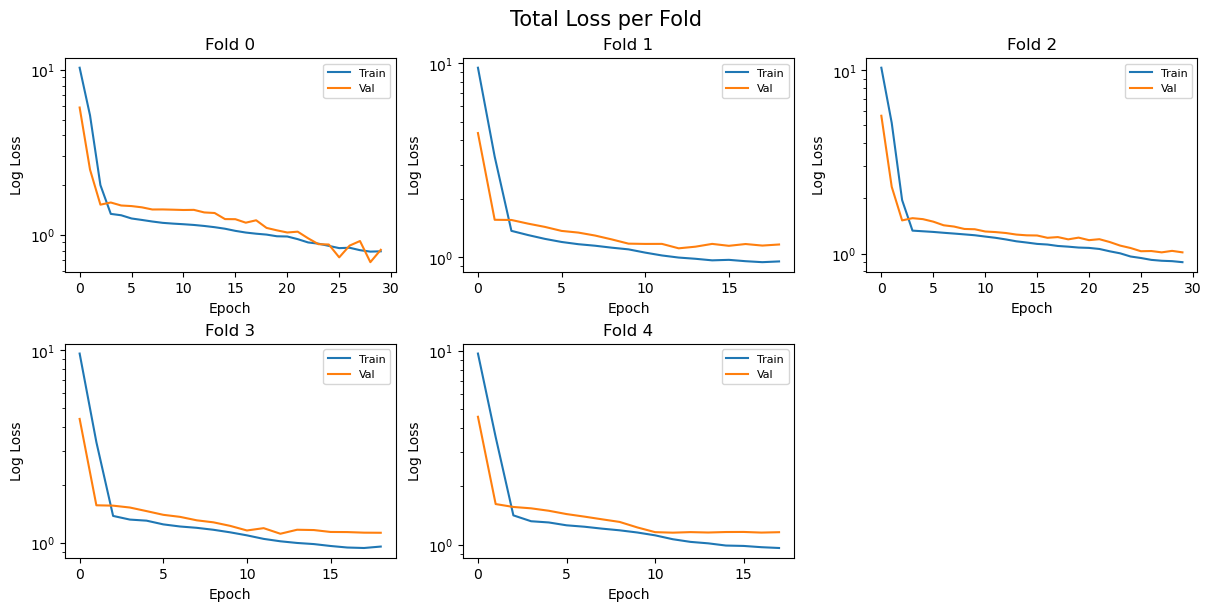

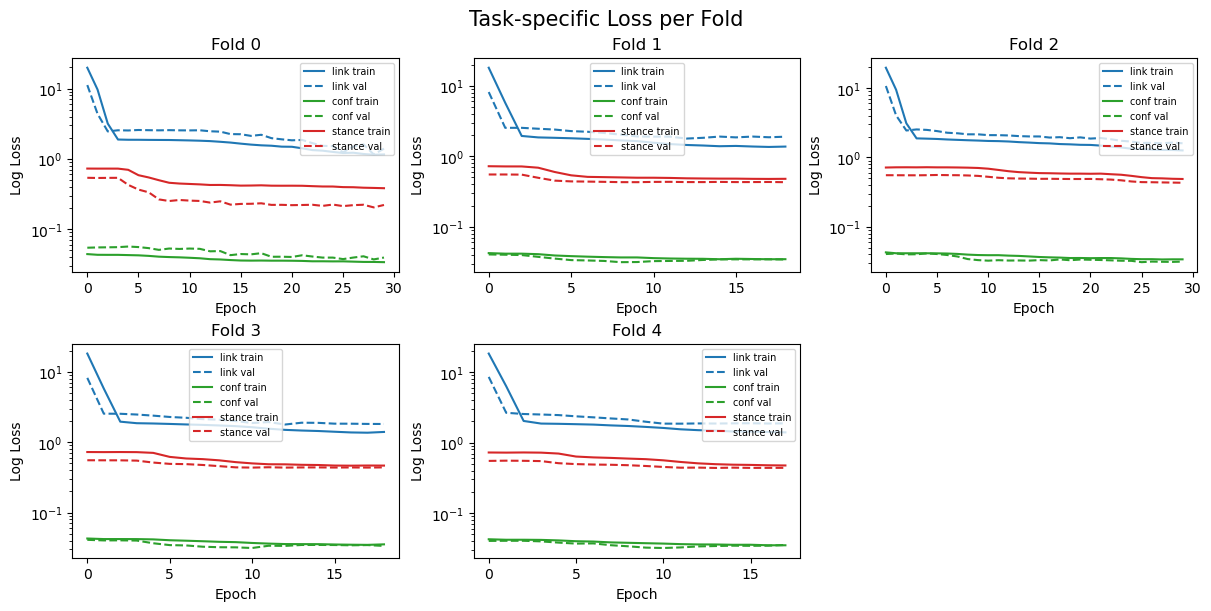

In [6]:
print("Training 3-ECC...")
_3ecc_model, _3ecc_results, _3ecc_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-ECC'] = _3ecc_results
TRAINED_MODELS['3-ECC'] = _3ecc_model

### **1-ECC-2-SAGE** (Full)

Training 1-ECC-2-SAGE...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
 

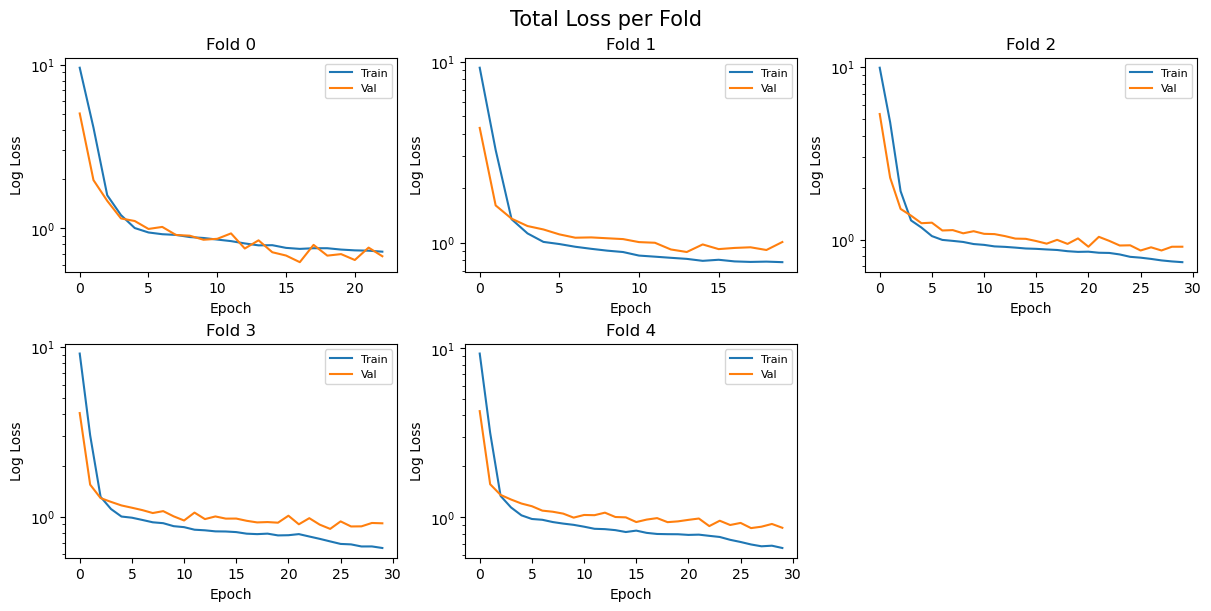

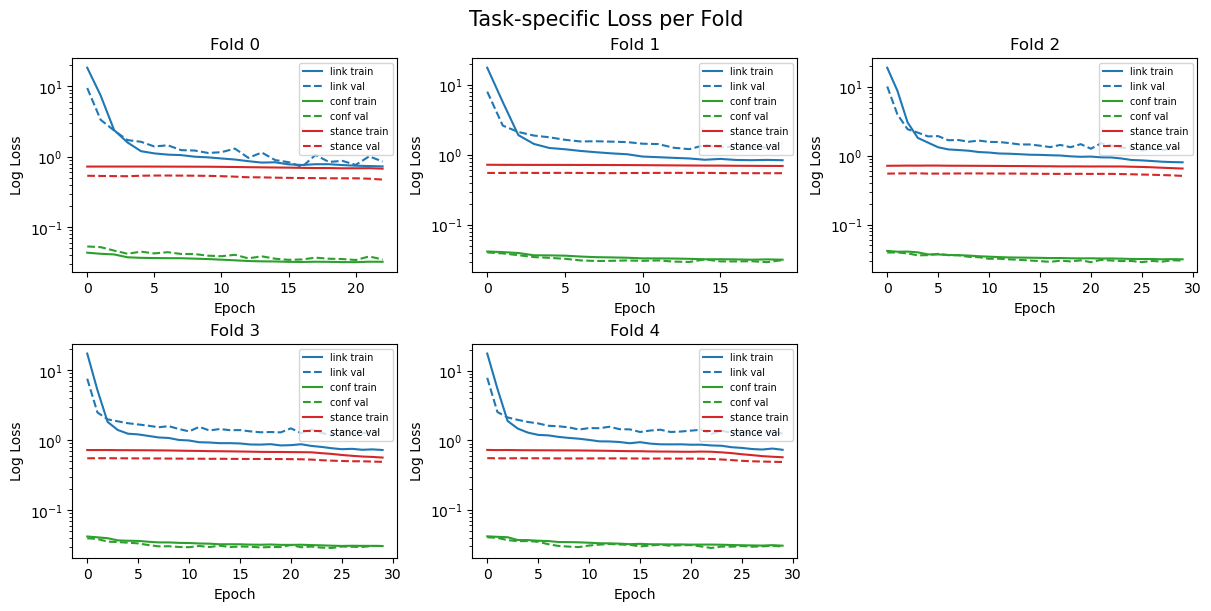

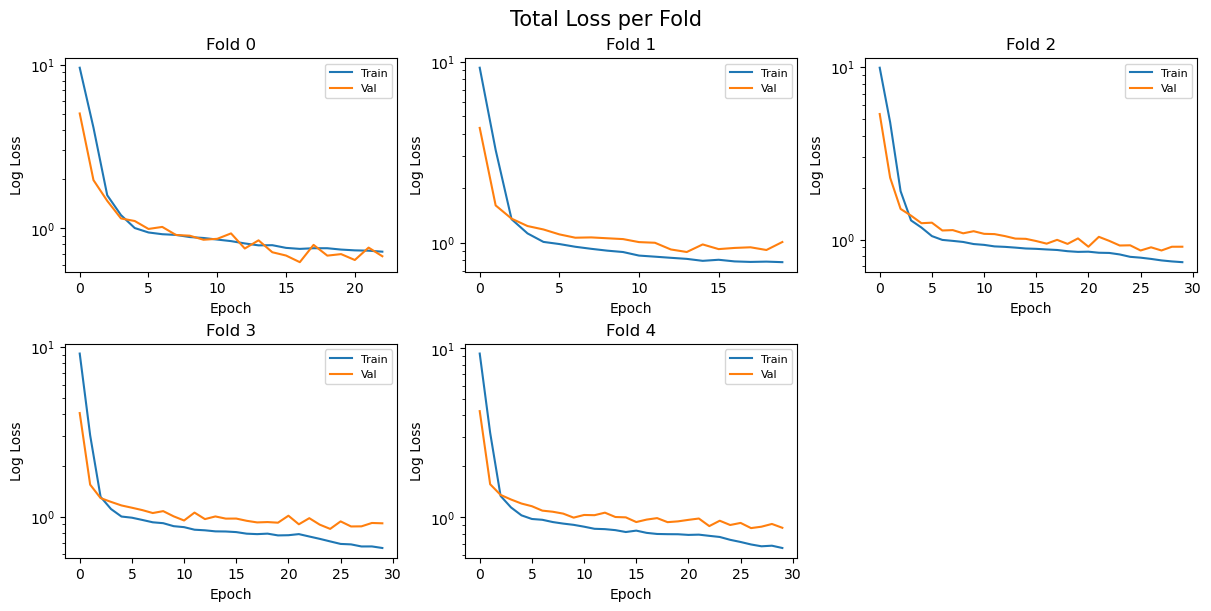

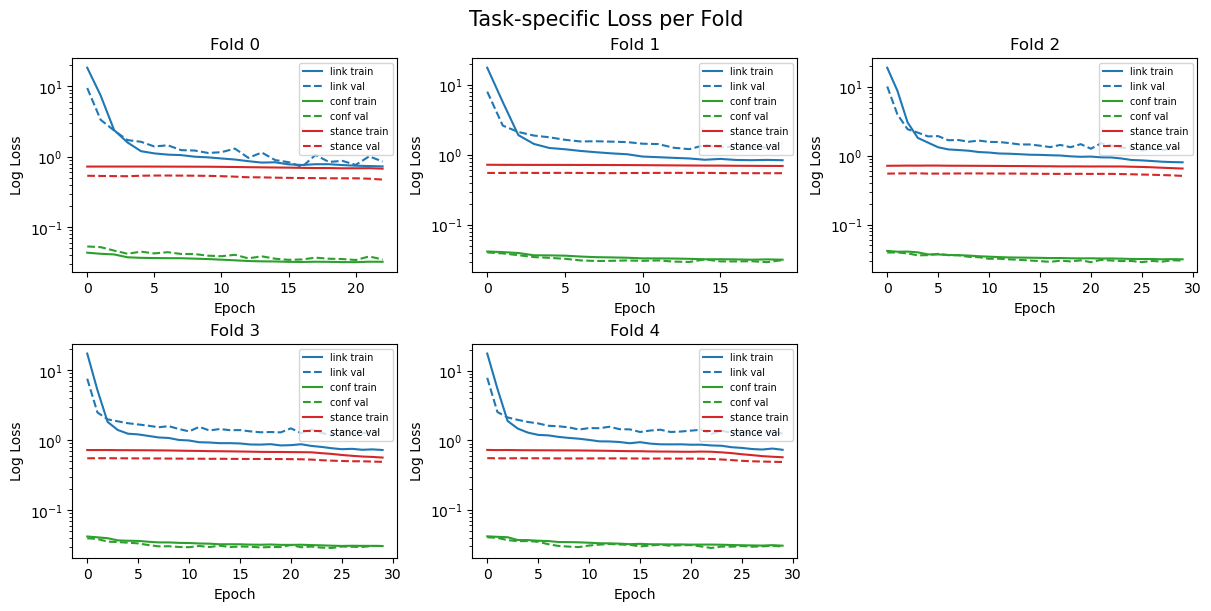

In [7]:
print("Training 1-ECC-2-SAGE...")
_1ecc_2sage_F_model, _1ecc_2sage_F_results, _1ecc_2sage_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _1ecc_2sage_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['1-ECC-2-SAGE'] = _1ecc_2sage_F_results
TRAINED_MODELS['1-ECC-2-SAGE'] = _1ecc_2sage_F_model

### **1-SAGE-2-ECC** (Full)

Training 1-SAGE-2-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
 

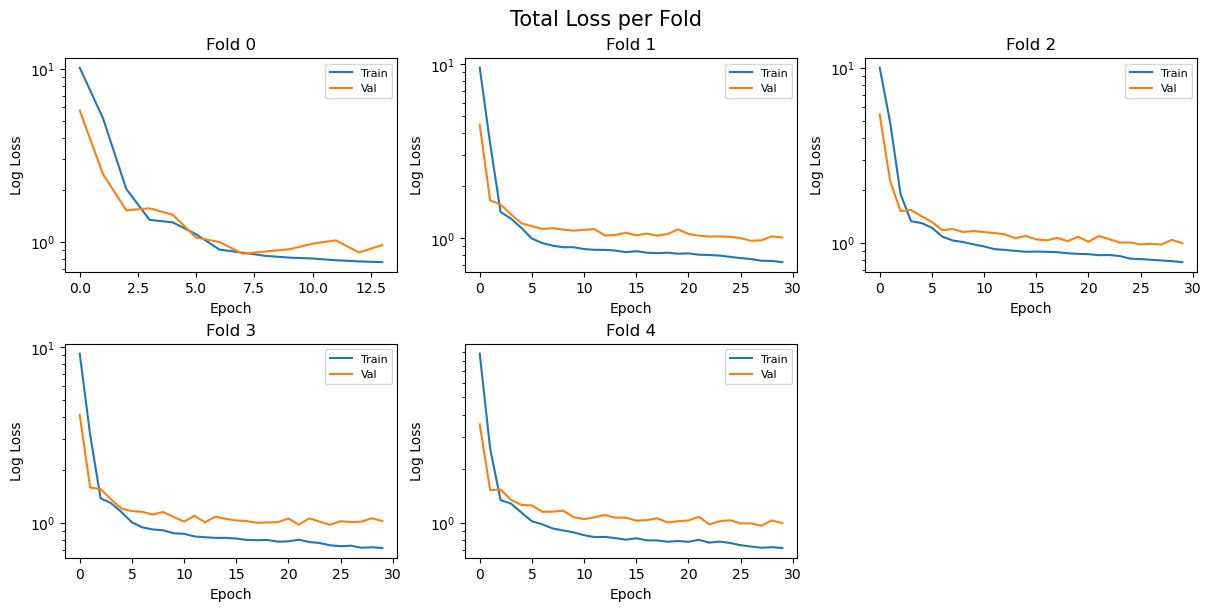

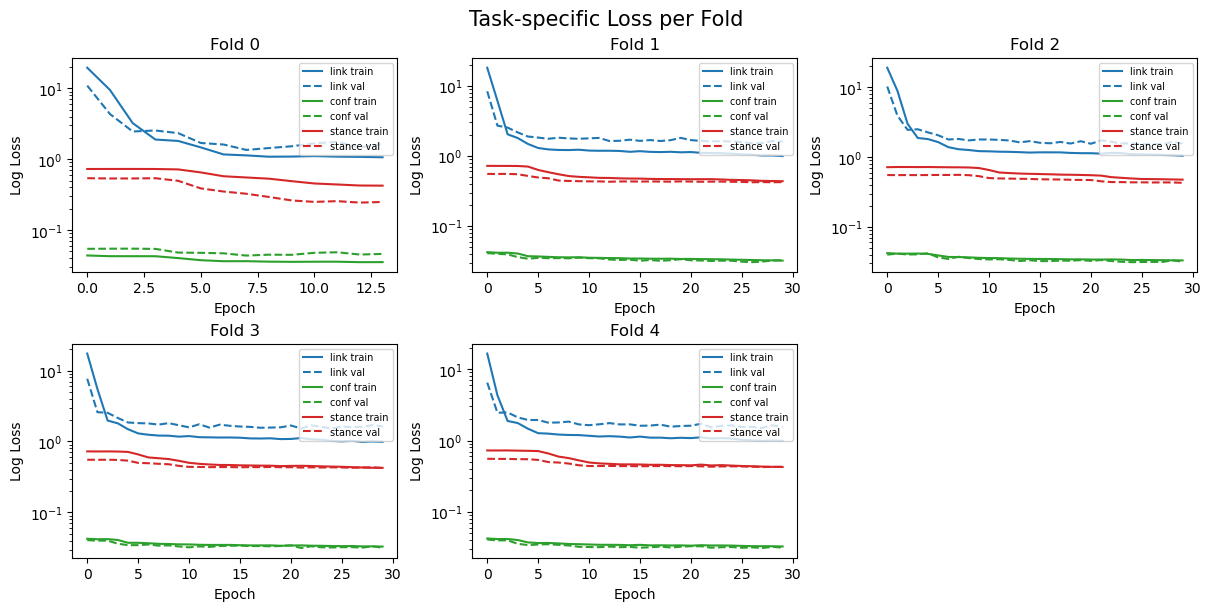

In [8]:
print("Training 1-SAGE-2-ECC...")
_1sage_2ecc_F_model, _1sage_2ecc_F_results, _1sage_2ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _1sage_2ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['1-SAGE-2-ECC'] = _1sage_2ecc_F_results
TRAINED_MODELS['1-SAGE-2-ECC'] = _1sage_2ecc_F_model

### **2-SAGE-1-ECC** (Full)

Training 2-SAGE-1-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
 

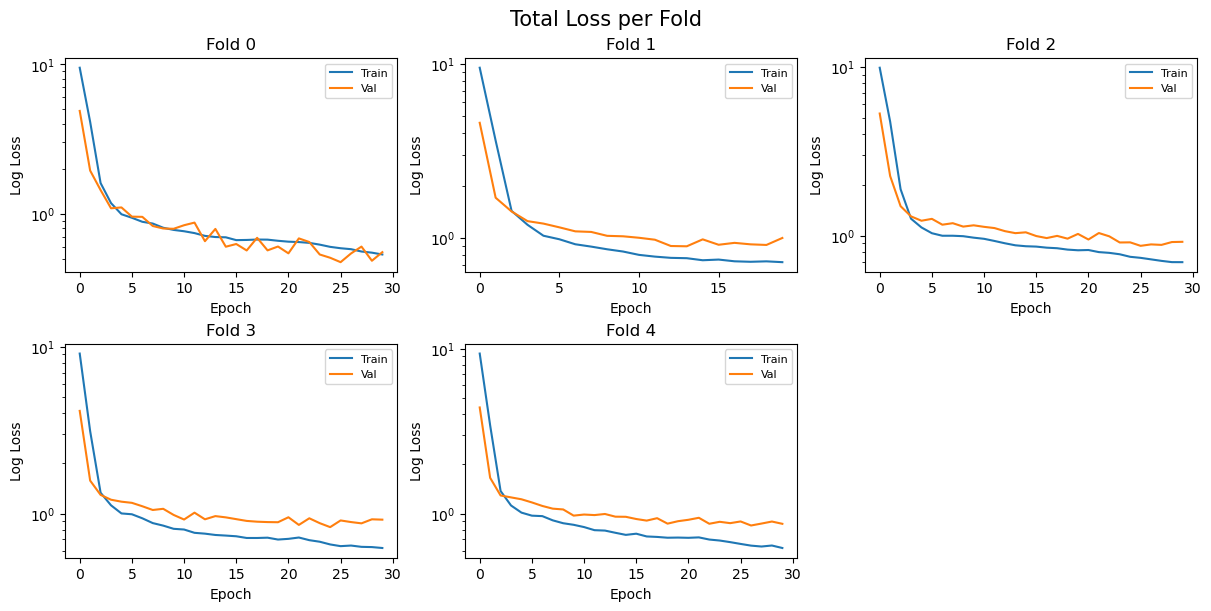

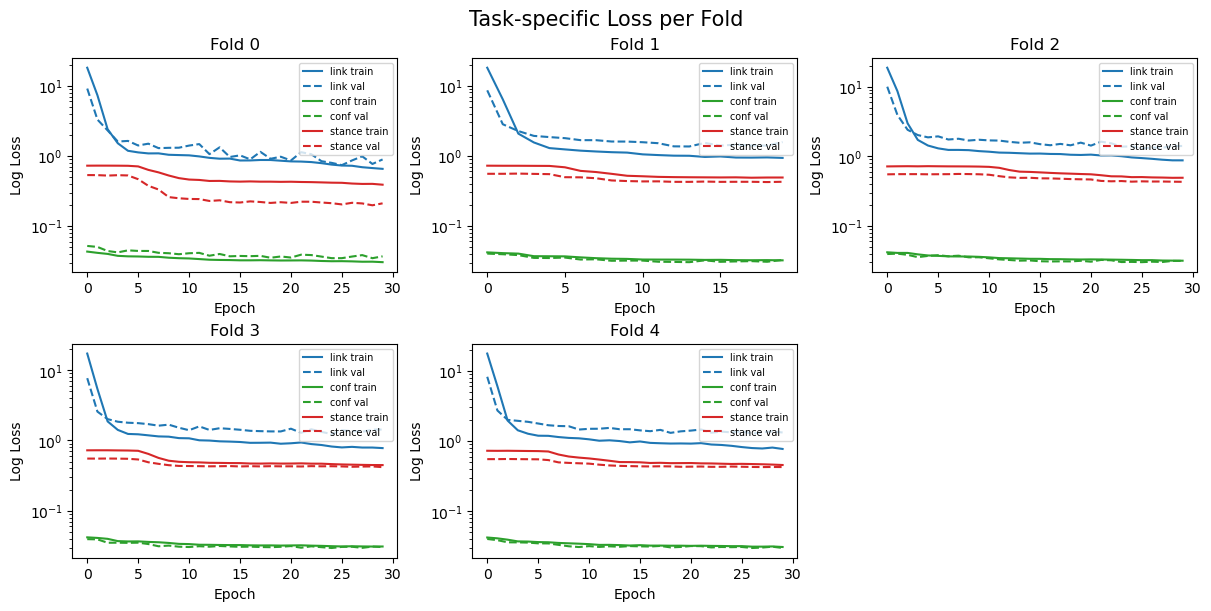

In [9]:
print("Training 2-SAGE-1-ECC...")
_2sage_1ecc_F_model, _2sage_1ecc_F_results, _2sage_1ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _2sage_1ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['2-SAGE-1-ECC'] = _2sage_1ecc_F_results
TRAINED_MODELS['2-SAGE-1-ECC'] = _2sage_1ecc_F_model

### **FINAL RESULTS**

In [10]:
import pandas as pd

records = []
for variant, fold_dict in TRAIN_RESULTS.items():
    for fold_id, metrics in fold_dict.items():
        rec = {"variant": variant, "fold": fold_id}
        rec.update(metrics)
        records.append(rec)

df = pd.DataFrame.from_records(records)
wide = (df.pivot(index="fold", columns="variant").sort_index())
wide.loc["MEAN"] = wide.mean()
wide = wide.round(3)
wide

link_auc                                      conf_mae  \
variant 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE   
fold                                                                 
0              0.793        0.641        0.834  0.779        0.344   
1              0.909        0.876        0.892  0.807        0.374   
2              0.917        0.861        0.900  0.862        0.353   
3              0.928        0.881        0.917  0.833        0.349   
4              0.921        0.880        0.914  0.808        0.354   
MEAN           0.894        0.828        0.892  0.818        0.355   

                                             conf_nll               \
variant 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE 1-SAGE-2-ECC   
fold                                                                 
0              0.319        0.346  0.327        0.699        0.709   
1              0.345        0.352  0.337        0.690        0.749   
2              0.343        0.342  0.335        0.724        0.791   
3              0.340        0.345  0.337        0.709        0.712   
4              0.344        0.344  0.331        0.715        0.733   
MEAN           0.338        0.346  0.333        0.708        0.739   

                              stance_nll                                   \
variant 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC   
fold                                                                        
0              0.703  0.696        1.091        0.991        0.872  0.826   
1              0.696  0.712        1.107        0.361        0.357  0.423   
2              0.731  0.778        1.081        0.559        0.549  0.608   
3              0.700  0.693        0.985        0.588        0.587  0.640   
4              0.722  0.749        0.933        0.548        0.567  0.674   
MEAN           0.710  0.726        1.039        0.609        0.586  0.634   

           stance_kl                                   
variant 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC  
fold                                                   
0              1.061        0.961        0.842  0.796  
1              1.104        0.358        0.353  0.419  
2              1.079        0.557        0.547  0.606  
3              0.983        0.585        0.584  0.638  
4              0.931        0.546        0.565  0.672  
MEAN           1.032        0.601        0.578  0.626

In [11]:
df_mean = df.drop(columns="fold").groupby("variant").mean(numeric_only=True).round(3)
df_mean

,link_auc,conf_mae,conf_nll,stance_nll,stance_kl
variant,,,,,
1-ECC-2-SAGE,0.894,0.355,0.708,1.039,1.032
1-SAGE-2-ECC,0.828,0.338,0.739,0.609,0.601
2-SAGE-1-ECC,0.892,0.346,0.710,0.586,0.578
3-ECC,0.818,0.333,0.726,0.634,0.626


In [12]:
print("Saved summary to 'results/ablation_summary.csv'")
df_mean.to_csv("results/ablation_summary.csv")

print("Saved all fold results to 'results/ablation_all_folds.csv'")
wide.to_csv("results/ablation_all_folds.csv")

Saved summary to 'results/ablation_summary.csv'
Saved all fold results to 'results/ablation_all_folds.csv'


### **Save Best Model (2-SAGE-1-ECC)**

In [14]:
import importlib
import src.utils
importlib.reload(src.utils)

from src.utils import save_model_checkpoint

best_model = TRAINED_MODELS['2-SAGE-1-ECC']
assert best_model is not None, "Model not found."
best_model_args = _2sage_1ecc_F_margs
best_model_train_args = BASE_TRAIN_ARGS

path = save_model_checkpoint(
    best_model, 
    best_model_args, 
    best_model_train_args,
    out_dir="checkpoints", 
    prefix="best_model"
)
print(f"Best model checkpoint path: {path}")

Saved model checkpoint to checkpoints/best_model_2508272148.pth
Best model checkpoint path: checkpoints/best_model_2508272148.pth
